## Import Packages

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.linalg
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision
from cca_core import flatten_weights
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torchvision.models import resnet50, ResNet50_Weights
import seaborn as sns
import torchvision.models as models
import pandas as pd
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from numpy.linalg import LinAlgError
import pickle
import os
import sys
import re
import itertools
import random
from scipy import stats
from torch.utils.data import Subset
from sklearn.exceptions import ConvergenceWarning
import warnings

## Style Settings

In [2]:

# Set color palettes
dark_green = '#006400'
dark_red = '#8b0000'
pal = {'Trained': dark_green, 'Untrained': dark_red}
light_green = '#90ee90'
light_red = '#ffcccb'
face_palette = sns.color_palette([light_green, light_red])

# Increase font size and thickness of axes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 2,
    'xtick.major.width': 2.5,
    'ytick.major.width': 2.5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'xtick.major.size': 10,
    'ytick.major.size': 10,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5
})

In [3]:
# Significance annotation function
# Annotate significance
def add_stat_annotation(ax, x, y, data, hue, p_values):
    # Get the unique modules
    modules = data[x].unique()
    y_max = data[y].max()
    
    for module in modules:
        # Calculate positions for annotations
        trained_data = data[(data[x] == module) & (data[hue] == 'Trained')][y]
        untrained_data = data[(data[x] == module) & (data[hue] == 'Untrained')][y]
        y_min, y_max_trained = trained_data.min(), trained_data.max()
        y_min_untrained, y_max_untrained = untrained_data.min(), untrained_data.max()
        y_max_plot = max(y_max_trained, y_max_untrained)
        
        # Retrieve the p-value
        p_value = p_values[module]
        
        # Determine annotation text
        if p_value < 0.001:
            annotation = '***'
        elif p_value < 0.01:
            annotation = '**'
        elif p_value < 0.05:
            annotation = '*'
        else:
            annotation = 'ns'
        
        # Add the annotation
        ax1.text(list(modules).index(module), y_max_plot + 0.03*y_max, annotation, 
                ha='center', va='bottom', color='black', fontsize=14, weight='bold')

## Import Resnet Models

In [4]:
# download trained and untrained models from torchvision
resnet_untrained = resnet50(pretrained=False)
# weights = ResNet50_Weights.IMAGENET1K_V2
resnet = resnet50(pretrained=True)

# Step 2: Set the models to eval
resnet_untrained.eval()
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Extract Weights

In [5]:
class ActivationExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.activations = {}
        
        def get_activation(name):
            def hook(module, input, output):
                self.activations[name] = input[0].detach()
            return hook
        
        # Hook for input to layer1 (output of initial layers)
        self.model.relu.register_forward_hook(get_activation("input_to_layer1"))
        
        for name, module in self.model.named_modules():
            if isinstance(module, models.resnet.Bottleneck):
                # Capture input to conv1
                module.conv1.register_forward_hook(get_activation(f"{name}_into_conv1"))
                
                # Capture input to conv2
                module.conv2.register_forward_hook(get_activation(f"{name}_into_conv2"))
                
                # Capture input to conv3
                module.conv3.register_forward_hook(get_activation(f"{name}_into_conv3"))
                
                # Capture input to downsample
                if module.downsample is not None:
                    module.downsample[0].register_forward_hook(get_activation(f"{name}_downsample_input"))
                
                # Capture output of the bottleneck block (after the final ReLU)
                module.relu.register_forward_hook(get_activation(f"{name}_output"))

    def forward(self, x):
        return self.model(x)


    
def get_activations(model, images):
    extractor = ActivationExtractor(model)
    extractor.eval()
    with torch.no_grad():
        _ = extractor(images)
    return extractor.activations

def print_activations(activations):
    input_types = {
        'input_to_layer1': [],
        'input_to_conv1': [],
        'input_to_conv2': [],
        'input_to_conv3': [],
        'input_to_downsample': [],
        'block_outputs': []
    }

    for name, activation in activations.items():
        if name == 'input_to_layer1':
            input_types['input_to_layer1'].append((name, activation))
        elif name.endswith('_into_conv1'):
            input_types['input_to_conv1'].append((name, activation))
        elif name.endswith('_into_conv2'):
            input_types['input_to_conv2'].append((name, activation))
        elif name.endswith('_into_conv3'):
            input_types['input_to_conv3'].append((name, activation))
        elif name.endswith('_downsample_input'):
            input_types['input_to_downsample'].append((name, activation))
        elif name.endswith('_output'):
            input_types['block_outputs'].append((name, activation))

    # Print activations
    for input_type, activations_list in input_types.items():
        print(f"\n{input_type.replace('_', ' ').upper()}:")
        for layer_name, activation in activations_list:
            print(f"  {layer_name}:")
            print(f"    Shape: {activation.shape}")

In [6]:
# # print all conv layers in resnet 
# for name, module in resnet.named_modules():
#     if isinstance(module, torch.nn.Conv2d):
#         print(name, module.weight.shape)

## Visualizing Feature Maps Across Depth

In [7]:
model = resnet

# Define the ImageNet normalization and transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# to perform the analysis, you must make a free accound on image-net.org and download the images. I downloaded the validation image set for 2012 (6.3 GB) 
# along with the development kits and placed them in my data folder
# Load ImageNet 2012 validation dataset
imagenet_data = datasets.ImageNet(root='Replace with path to ImageNet2012Val data', split='val', transform=preprocess)
# Create a subset of the dataset
subset_indices = range(1000)
subset_data = Subset(imagenet_data, subset_indices)

# Create a DataLoader for the subset
data_loader = DataLoader(subset_data, batch_size=10, shuffle=True)
# Collect 1000 activations
# Collect and print activations for 1000 images
for images, _ in data_loader:
    activations = get_activations(model, images)
    break  # Remove this break statement if you want to process all batches

# # Print the number of activations collected
# for key, value in activations.items():
#     print(f"{key}: {value.shape}")

/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_3889/3097351734.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


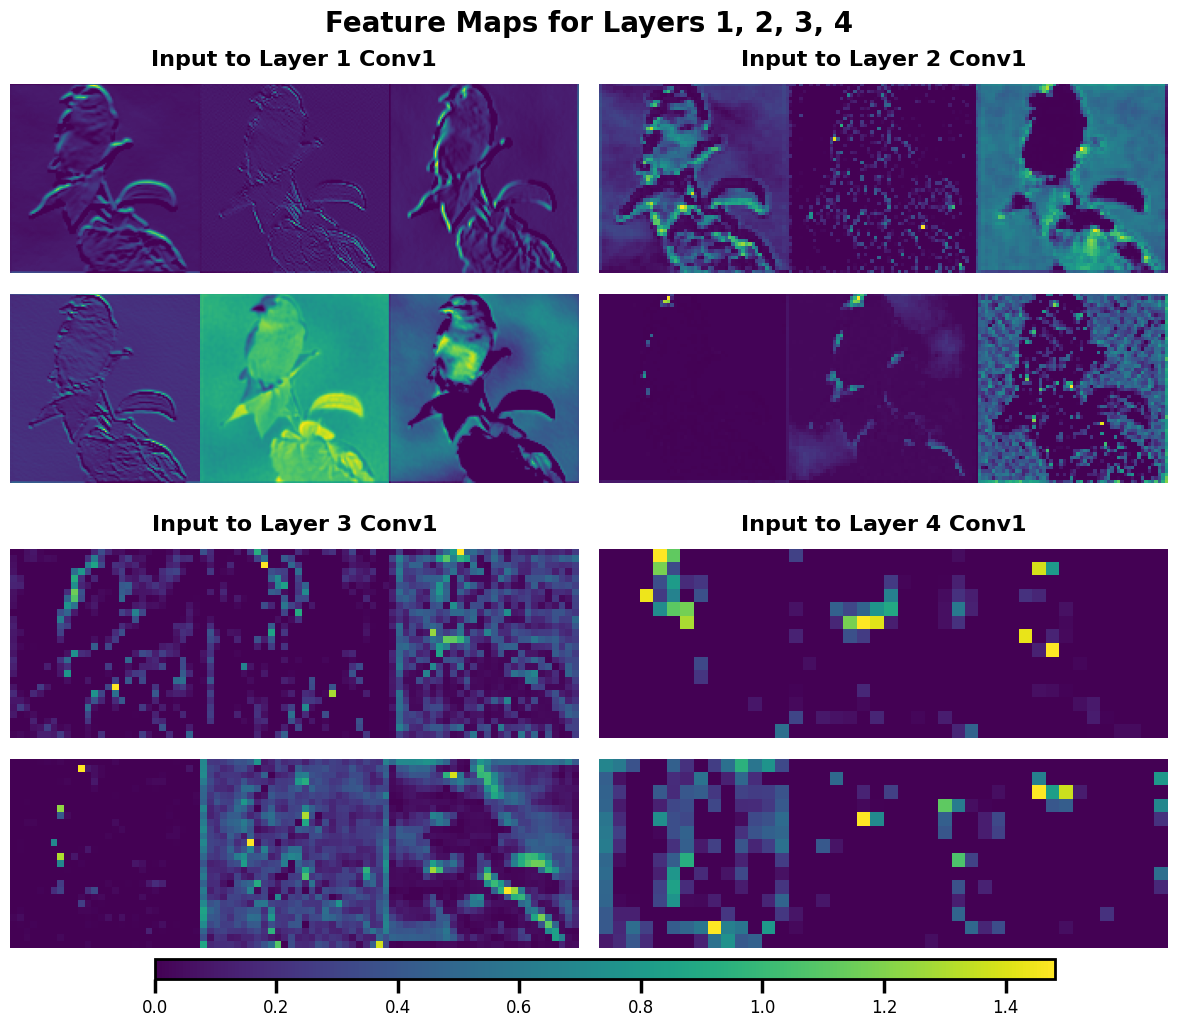

In [8]:
def visualize_activations(activations_dict, title, file_path, file_name):
    # Extract the relevant activations and take the first 6 feature maps for a 2x3 grid
    layer1_conv2 = activations_dict['input_to_layer1'][0][:6]
    layer2_conv1 = activations_dict['layer2.0_into_conv1'][0][:6]
    layer3_conv1 = activations_dict['layer3.0_into_conv1'][0][:6]
    layer4_conv1 = activations_dict['layer4.0_into_conv1'][0][:6]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 grid of plots

    layers = [
        (layer1_conv2, 'Input to Layer 1 Conv1'),
        (layer2_conv1, 'Input to Layer 2 Conv1'),
        (layer3_conv1, 'Input to Layer 3 Conv1'),
        (layer4_conv1, 'Input to Layer 4 Conv1')
    ]

    for ax, (layer, layer_title) in zip(axes.flatten(), layers):
        # Set the grid size to 2x3
        rows, cols = 2, 3

        for i in range(layer.shape[0]):
            ax_i = ax.inset_axes([(i % cols) / cols, (i // cols) / rows, 1 / cols, 1 / rows])
            fmap = layer[i].cpu().numpy()
            im = ax_i.imshow(fmap, cmap='viridis')
            ax_i.axis('off')

        ax.set_title(layer_title, fontweight='bold')
        ax.axis('off')  # Turn off the main axes

    fig.subplots_adjust(bottom=0.15, top=0.85, hspace=0, wspace=0)
    
    # Create a colorbar at the bottom
    cbar_ax = fig.add_axes([0.138, 0, 0.75, 0.02])
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')  # Use the last image for the colorbar

    plt.suptitle(title, y=0.97, fontweight='bold', fontsize=20)  
    plt.tight_layout()
    # plt.savefig(os.path.join(file_path, file_name), dpi=300, bbox_inches='tight')
    plt.show()
# Assuming activations is the dictionary with all collected activations
visualize_activations(activations, 'Feature Maps for Layers 1, 2, 3, 4', file_path, file_name)

## Unroll the Activations for processing

In [9]:
class ActivationExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.activations = {}
        
        def get_activation(name, unfold_layer=None):
            def hook(module, input, output):
                activation = input[0].detach()
                if unfold_layer:
                    unfolded_activation = unfold_layer(activation)
                    unfolded_activation = unfolded_activation.view(activation.shape[0], -1, unfolded_activation.shape[-1])
                    self.activations[name] = unfolded_activation
                else:
                    self.activations[name] = activation
            return hook
        
        # Hook for input to layer1 (output of initial layers)
        conv1_params = model.conv1
        conv1_unfold = nn.Unfold(kernel_size=conv1_params.kernel_size, 
                                 dilation=conv1_params.dilation,
                                 padding=conv1_params.padding,
                                 stride=conv1_params.stride)
        self.model.relu.register_forward_hook(get_activation("input_to_layer1", conv1_unfold))
        
        for name, module in self.model.named_modules():
            if isinstance(module, models.resnet.Bottleneck):
                # Capture and unfold input to conv1
                conv1_unfold = nn.Unfold(kernel_size=module.conv1.kernel_size, 
                                         dilation=module.conv1.dilation,
                                         padding=module.conv1.padding,
                                         stride=module.conv1.stride)
                module.conv1.register_forward_hook(get_activation(f"{name}_into_conv1", conv1_unfold))
                
                # Capture and unfold input to conv2
                conv2_unfold = nn.Unfold(kernel_size=module.conv2.kernel_size, 
                                         dilation=module.conv2.dilation,
                                         padding=module.conv2.padding,
                                         stride=module.conv2.stride)
                module.conv2.register_forward_hook(get_activation(f"{name}_into_conv2", conv2_unfold))
                
                # Capture and unfold input to conv3
                conv3_unfold = nn.Unfold(kernel_size=module.conv3.kernel_size, 
                                         dilation=module.conv3.dilation,
                                         padding=module.conv3.padding,
                                         stride=module.conv3.stride)
                module.conv3.register_forward_hook(get_activation(f"{name}_into_conv3", conv3_unfold))
                
                # Capture and unfold input to downsample
                if module.downsample is not None:
                    downsample_conv = module.downsample[0]
                    downsample_unfold = nn.Unfold(kernel_size=downsample_conv.kernel_size,
                                                  dilation=downsample_conv.dilation,
                                                  padding=downsample_conv.padding,
                                                  stride=downsample_conv.stride)
                    module.downsample[0].register_forward_hook(get_activation(f"{name}_downsample_input", downsample_unfold))
                
                # Capture output of the bottleneck block (after the final ReLU)
                module.relu.register_forward_hook(get_activation(f"{name}_output"))

    def forward(self, x):
        return self.model(x)

    
def get_activations(model, images):
    extractor = ActivationExtractor(model)
    extractor.eval()
    with torch.no_grad():
        _ = extractor(images)
    return extractor.activations

def print_activations(activations):
    input_types = {
        'input_to_layer1': [],
        'input_to_conv1': [],
        'input_to_conv2': [],
        'input_to_conv3': [],
        'input_to_downsample': [],
        'block_outputs': []
    }

    for name, activation in activations.items():
        if name == 'input_to_layer1':
            input_types['input_to_layer1'].append((name, activation))
        elif name.endswith('_into_conv1'):
            input_types['input_to_conv1'].append((name, activation))
        elif name.endswith('_into_conv2'):
            input_types['input_to_conv2'].append((name, activation))
        elif name.endswith('_into_conv3'):
            input_types['input_to_conv3'].append((name, activation))
        elif name.endswith('_downsample_input'):
            input_types['input_to_downsample'].append((name, activation))
        elif name.endswith('_output'):
            input_types['block_outputs'].append((name, activation))

    # Print activations
    for input_type, activations_list in input_types.items():
        print(f"\n{input_type.replace('_', ' ').upper()}:")
        for layer_name, activation in activations_list:
            print(f"  {layer_name}:")
            print(f"    Shape: {activation.shape}")

### Note:
This is currently set to take 5 images from the validation set and compare the alignment to minimize computational load. For our study we did this for 100 images. To fully replicate requires a large amount of RAM. The results of the full analysis can be found in the pickle file the Github repo. 

In [10]:
subset_indices = range(1000)
subset_data = Subset(imagenet_data, subset_indices)

# Create a DataLoader for the subset
data_loader = DataLoader(subset_data, batch_size=5, shuffle=True)
# Collect 1000 activations
# Collect and print activations for 5 images
for images, _ in data_loader:
    activations_trained = get_activations(model, images)
    break  # Remove this break statement if you want to process all batches

print_activations(activations_trained)


INPUT TO LAYER1:
  input_to_layer1:
    Shape: torch.Size([5, 3136, 3136])

INPUT TO CONV1:
  layer1.0_into_conv1:
    Shape: torch.Size([5, 64, 3136])
  layer1.1_into_conv1:
    Shape: torch.Size([5, 256, 3136])
  layer1.2_into_conv1:
    Shape: torch.Size([5, 256, 3136])
  layer2.0_into_conv1:
    Shape: torch.Size([5, 256, 3136])
  layer2.1_into_conv1:
    Shape: torch.Size([5, 512, 784])
  layer2.2_into_conv1:
    Shape: torch.Size([5, 512, 784])
  layer2.3_into_conv1:
    Shape: torch.Size([5, 512, 784])
  layer3.0_into_conv1:
    Shape: torch.Size([5, 512, 784])
  layer3.1_into_conv1:
    Shape: torch.Size([5, 1024, 196])
  layer3.2_into_conv1:
    Shape: torch.Size([5, 1024, 196])
  layer3.3_into_conv1:
    Shape: torch.Size([5, 1024, 196])
  layer3.4_into_conv1:
    Shape: torch.Size([5, 1024, 196])
  layer3.5_into_conv1:
    Shape: torch.Size([5, 1024, 196])
  layer4.0_into_conv1:
    Shape: torch.Size([5, 1024, 196])
  layer4.1_into_conv1:
    Shape: torch.Size([5, 2048, 49]

In [11]:
for images, _ in data_loader:
    activations_untrained = get_activations(resnet_untrained, images)
    break  # Remove this break statement if you want to process all batches
# # # Print the number of activations collected
# for key, value in activations_untrained.items():
#     print(f"{key}: {value.shape}")

# # only print keys with _input in them
for key, value in activations_untrained.items():
    if 'input' in key or 'into' in key:
        print(f"{key}: {value.shape}")

input_to_layer1: torch.Size([5, 3136, 3136])
layer1.0_into_conv1: torch.Size([5, 64, 3136])
layer1.0_into_conv2: torch.Size([5, 576, 3136])
layer1.0_into_conv3: torch.Size([5, 64, 3136])
layer1.0_downsample_input: torch.Size([5, 64, 3136])
layer1.1_into_conv1: torch.Size([5, 256, 3136])
layer1.1_into_conv2: torch.Size([5, 576, 3136])
layer1.1_into_conv3: torch.Size([5, 64, 3136])
layer1.2_into_conv1: torch.Size([5, 256, 3136])
layer1.2_into_conv2: torch.Size([5, 576, 3136])
layer1.2_into_conv3: torch.Size([5, 64, 3136])
layer2.0_into_conv1: torch.Size([5, 256, 3136])
layer2.0_into_conv2: torch.Size([5, 1152, 784])
layer2.0_into_conv3: torch.Size([5, 128, 784])
layer2.0_downsample_input: torch.Size([5, 256, 784])
layer2.1_into_conv1: torch.Size([5, 512, 784])
layer2.1_into_conv2: torch.Size([5, 1152, 784])
layer2.1_into_conv3: torch.Size([5, 128, 784])
layer2.2_into_conv1: torch.Size([5, 512, 784])
layer2.2_into_conv2: torch.Size([5, 1152, 784])
layer2.2_into_conv3: torch.Size([5, 128, 

In [12]:
# get the number of avctivations for each layer ( the batch dimension of the activations)
num_activations = activations['input_to_layer1'].shape[0]
print(num_activations)
print(range(num_activations))

5
range(0, 5)


In [13]:
# print all conv layers in resnet 
for name, module in resnet.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(name, module.weight.shape)

conv1 torch.Size([64, 3, 7, 7])
layer1.0.conv1 torch.Size([64, 64, 1, 1])
layer1.0.conv2 torch.Size([64, 64, 3, 3])
layer1.0.conv3 torch.Size([256, 64, 1, 1])
layer1.0.downsample.0 torch.Size([256, 64, 1, 1])
layer1.1.conv1 torch.Size([64, 256, 1, 1])
layer1.1.conv2 torch.Size([64, 64, 3, 3])
layer1.1.conv3 torch.Size([256, 64, 1, 1])
layer1.2.conv1 torch.Size([64, 256, 1, 1])
layer1.2.conv2 torch.Size([64, 64, 3, 3])
layer1.2.conv3 torch.Size([256, 64, 1, 1])
layer2.0.conv1 torch.Size([128, 256, 1, 1])
layer2.0.conv2 torch.Size([128, 128, 3, 3])
layer2.0.conv3 torch.Size([512, 128, 1, 1])
layer2.0.downsample.0 torch.Size([512, 256, 1, 1])
layer2.1.conv1 torch.Size([128, 512, 1, 1])
layer2.1.conv2 torch.Size([128, 128, 3, 3])
layer2.1.conv3 torch.Size([512, 128, 1, 1])
layer2.2.conv1 torch.Size([128, 512, 1, 1])
layer2.2.conv2 torch.Size([128, 128, 3, 3])
layer2.2.conv3 torch.Size([512, 128, 1, 1])
layer2.3.conv1 torch.Size([128, 512, 1, 1])
layer2.3.conv2 torch.Size([128, 128, 3, 3])


In [14]:
def grid_search_and_store_angles(V1, V2, V1_untrained, V2_untrained, S1, S2, S1_untrained, S2_untrained, layer_name):
    """
    Parameters:
    - V1: V/U SVD matrix for the trained model - This is the V matrix with the eigenbasis vecotors as columns (Aka the transposed version of the default V matrix from svd)
    - V2: V/U SVD matrix for the trained model
    - V1_untrained: U/V SVD matrix for the untrained model
    - V2_untrained: U/V SVD matrix for the untrained model
    - S1: SVD Singular values matrix for the trained model
    - S2: SVD Singular values matrix for the trained model
    - S1_untrained: Singular values for the untrained model
    - S2_untrained: Singular values for the untrained model
    - layer_name: Name of the layer

    Perform a grid search to find the best number of columns to use for the given layers.
    with the layer names that you want to compare. The primary grid search looks for the first valid combination of columns that has angles greater than 1e-1.
    If no valid combinations are found, the secondary grid search is performed to find the best combination of columns that maximizes the number of angles greater than 1e-1.
    Explained variance is calculated for the best combination of columns found in the primary or secondary grid search based on the number of columns used. 

    Outputs:
    - valid_combinations: List of tuples containing the number of rows and columns for the best combination of columns found
    - angles_trained: List of angles between the trained layers
    - angles_untrained: List of angles between the untrained layers
    - layer_names: List of layer names
    - explained_variances_trained: List of explained variances for the trained layers
    - explained_variances_untrained: List of explained variances for the untrained layers

    """
    
    if V1.shape[0] != V2.shape[0] or V1_untrained.shape[0] != V2_untrained.shape[0]:
        raise ValueError('The number of rows in v/u matrices must be the same')
    # Truncate V1, V2, V1_untrained, V2_untrained to the same dimensions
    min_cols = min(V1.shape[1], V2.shape[1], V1_untrained.shape[1], V2_untrained.shape[1])
    V1 = V1[:, :min_cols]
    V2 = V2[:, :min_cols]
    V1_untrained = V1_untrained[:, :min_cols]
    V2_untrained = V2_untrained[:, :min_cols]
    
    # Truncate singular values
    S1_original = S1.copy()
    S2_original = S2.copy()
    S1_untrained_original = S1_untrained.copy()
    S2_untrained_original = S2_untrained

    def calculate_explained_variance(S, num_cols):
        total_variance = np.sum(S**2)
        explained_variance = np.sum(S[:num_cols]**2) / total_variance
        return explained_variance

    def primary_grid_search(V1, V2, V1_untrained, V2_untrained, S1, S2, S1_untrained, S2_untrained):
        if min(V1.shape[1], V2.shape[1]) > 200:
            num_cols = np.arange(min(V1.shape[1], V2.shape[1]), np.ceil(min(V1.shape[1], V2.shape[1]) / 2), -50).astype(int)
        elif min(V1.shape[1], V2.shape[1]) > 100:
            num_cols = np.arange(min(V1.shape[1], V2.shape[1]), np.ceil(min(V1.shape[1], V2.shape[1]) / 2), -30).astype(int)
        else:
            num_cols = np.arange(min(V1.shape[1], V2.shape[1]), np.ceil(min(V1.shape[1], V2.shape[1]) / 2), -20).astype(int)

        valid_combinations = []
        angles_trained = []
        angles_untrained = []
        layer_names = []
        explained_variances_trained = []
        explained_variances_untrained = []

        found_valid = False
        rows = V1.shape[0]  # Use all rows
        for cols in num_cols:
            V1_subset = V1[:, :cols]
            V2_subset = V2[:, :cols]
            V1_untrained_subset = V1_untrained[:, :cols]
            V2_untrained_subset = V2_untrained[:, :cols]

            try:
                angle_trained = np.degrees(subspace_angles(V1_subset, V2_subset))
                angle_untrained = np.degrees(subspace_angles(V1_untrained_subset, V2_untrained_subset))

                if np.all(angle_trained > 1e-1) and np.all(angle_untrained > 1e-1):
                    valid_combinations.append((rows, cols))
                    angles_trained.append(angle_trained)
                    angles_untrained.append(angle_untrained)
                    layer_names.append(layer_name)
                    
                    # Calculate explained variance
                    ev_trained_1 = calculate_explained_variance(S1_original, cols)
                    ev_trained_2 = calculate_explained_variance(S2_original, cols)
                    ev_untrained_1 = calculate_explained_variance(S1_untrained_original, cols)
                    ev_untrained_2 = calculate_explained_variance(S2_untrained_original, cols)
                    
                    explained_variances_trained.append((ev_trained_1, ev_trained_2))
                    explained_variances_untrained.append((ev_untrained_1, ev_untrained_2))
                    
                    found_valid = True
                    break  # Stop after the first valid combination is found
            except LinAlgError:
                continue

        return valid_combinations, angles_trained, angles_untrained, layer_names, explained_variances_trained, explained_variances_untrained

    def secondary_grid_search(V1, V2, V1_untrained, V2_untrained, S1, S2, S1_untrained, S2_untrained):
        col_step = max(1, min(V1.shape[1], V2.shape[1]) // 20)
        num_cols = np.arange(min(V1.shape[1], V2.shape[1]), max(1, min(V1.shape[1], V2.shape[1]) // 2), -col_step).astype(int)

        best_combination = None
        best_angles_trained = None
        best_angles_untrained = None
        best_explained_variance_trained = None
        best_explained_variance_untrained = None
        max_count = 0

        rows = V1.shape[0]  # Use all rows
        for cols in num_cols:
            V1_subset = V1[:, :cols]
            V2_subset = V2[:, :cols]
            V1_untrained_subset = V1_untrained[:, :cols]
            V2_untrained_subset = V2_untrained[:, :cols]

            try:
                angle_trained = np.degrees(subspace_angles(V1_subset, V2_subset))
                angle_untrained = np.degrees(subspace_angles(V1_untrained_subset, V2_untrained_subset))

                count_above_threshold_trained = np.sum(angle_trained > 1e-1)
                count_above_threshold_untrained = np.sum(angle_untrained > 1e-1)

                if count_above_threshold_trained + count_above_threshold_untrained > max_count:
                    max_count = count_above_threshold_trained + count_above_threshold_untrained
                    best_combination = (rows, cols)
                    best_angles_trained = angle_trained[angle_trained > 1e-1]  # Filter angles
                    best_angles_untrained = angle_untrained[angle_untrained > 1e-1]  # Filter angles
                    
                    # Calculate explained variance for the best combination
                    ev_trained_1 = calculate_explained_variance(S1, cols)
                    ev_trained_2 = calculate_explained_variance(S2, cols)
                    ev_untrained_1 = calculate_explained_variance(S1_untrained, cols)
                    ev_untrained_2 = calculate_explained_variance(S2_untrained, cols)
                    
                    best_explained_variance_trained = (ev_trained_1, ev_trained_2)
                    best_explained_variance_untrained = (ev_untrained_1, ev_untrained_2)
            except LinAlgError:
                continue

        return best_combination, best_angles_trained, best_angles_untrained, best_explained_variance_trained, best_explained_variance_untrained

    valid_combinations, angles_trained, angles_untrained, layer_names, explained_variances_trained, explained_variances_untrained = primary_grid_search(V1, V2, V1_untrained, V2_untrained, S1, S2, S1_untrained, S2_untrained)

    if not valid_combinations:
        best_combination, best_angles_trained, best_angles_untrained, best_explained_variance_trained, best_explained_variance_untrained = secondary_grid_search(V1, V2, V1_untrained, V2_untrained, S1, S2, S1_untrained, S2_untrained)
        valid_combinations = [best_combination]  # Only return the best combination
        angles_trained = [best_angles_trained]
        angles_untrained = [best_angles_untrained]
        layer_names = [layer_name]
        explained_variances_trained = [best_explained_variance_trained]
        explained_variances_untrained = [best_explained_variance_untrained]

    return valid_combinations, angles_trained, angles_untrained, layer_names, explained_variances_trained, explained_variances_untrained

In [15]:
def extract_specific_weights(model, layers_to_extract=['conv1', 'conv2', 'conv3', 'downsample']):
    weights = {}
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            layer_type = name.split('.')[-1]
            if layer_type in layers_to_extract or (layer_type == 'conv1' and name.endswith('.0.conv1')):
                # Get the weight tensor
                weight = module.weight.data.clone().detach()
                
                # Get dimensions
                out_channels, in_channels, kernel_height, kernel_width = weight.shape
                
                # Create an Unfold layer with the same parameters as the Conv2d layer
                unfold = nn.Unfold(kernel_size=(kernel_height, kernel_width), 
                                   dilation=1,
                                   padding=0,
                                   stride=1)
                
                # Apply the Unfold operation
                unfolded_weight = unfold(weight)
                
                # Reshape to (out_channels, in_channels * kernel_height * kernel_width)
                unfolded_weight = unfolded_weight.view(out_channels, -1)
                print(f'Layer: {name}, Unfolded Weight Shape: {unfolded_weight.shape}')
                
                # Store the unfolded weight
                weights[name] = unfolded_weight.cpu().numpy()
                
        elif isinstance(module, (models.resnet.Bottleneck, models.resnet.BasicBlock)):
            if 'downsample' in layers_to_extract and hasattr(module, 'downsample') and module.downsample is not None:
                skip_conv_weight = module.downsample[0].weight.data.clone().detach()
                skip_out_channels, skip_in_channels, skip_kernel_height, skip_kernel_width = skip_conv_weight.shape
                
                # Create an Unfold layer with the same parameters as the downsample Conv2d layer
                unfold = nn.Unfold(kernel_size=(skip_kernel_height, skip_kernel_width),
                                   dilation=1,
                                   padding=0,
                                   stride=1)
                
                # Apply the Unfold operation
                unfolded_skip_weight = unfold(skip_conv_weight)
                
                # Reshape to (out_channels, in_channels * kernel_height * kernel_width)
                unfolded_skip_weight = unfolded_skip_weight.view(skip_out_channels, -1)
                print(f'Layer: {name + ".downsample"}, Unfolded Weight Shape: {unfolded_skip_weight.shape}')
                
                # Store the unfolded weight
                weights[name + '.downsample'] = unfolded_skip_weight
                
    return weights

In [16]:
trained_weights = extract_specific_weights(resnet)
untrained_weights = extract_specific_weights(resnet_untrained)
# print(trained_weights.keys())
# # print size of each weight layer
# for name, weight in trained_weights.items():
#     print(name, weight.shape)



Layer: conv1, Unfolded Weight Shape: torch.Size([64, 147])
Layer: layer1.0.downsample, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer1.0.conv1, Unfolded Weight Shape: torch.Size([64, 64])
Layer: layer1.0.conv2, Unfolded Weight Shape: torch.Size([64, 576])
Layer: layer1.0.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer1.1.conv1, Unfolded Weight Shape: torch.Size([64, 256])
Layer: layer1.1.conv2, Unfolded Weight Shape: torch.Size([64, 576])
Layer: layer1.1.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer1.2.conv1, Unfolded Weight Shape: torch.Size([64, 256])
Layer: layer1.2.conv2, Unfolded Weight Shape: torch.Size([64, 576])
Layer: layer1.2.conv3, Unfolded Weight Shape: torch.Size([256, 64])
Layer: layer2.0.downsample, Unfolded Weight Shape: torch.Size([512, 256])
Layer: layer2.0.conv1, Unfolded Weight Shape: torch.Size([128, 256])
Layer: layer2.0.conv2, Unfolded Weight Shape: torch.Size([128, 1152])
Layer: layer2.0.conv3, Unfolded Weight Shape

In [17]:
def analyze_direct_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare):
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'svd_explained_variances_trained': {},
        'svd_explained_variances_untrained': {},
        # 'pca_explained_variances_trained': {},
        # 'pca_explained_variances_untrained': {},
    }

    for layer_name in layers_to_compare:
        print(f'Analyzing direct connections for {layer_name}')
        
        for key in results.keys():
            results[key][layer_name] = []

        trained_weight = trained_weights[f'{layer_name}.conv2']
        untrained_weight = untrained_weights[f'{layer_name}.conv2']

        # Perform SVD on the weights
        try:
            _, S1_trained, V1_trained = np.linalg.svd(trained_weight, full_matrices=False)
            _, S1_untrained, V1_untrained = np.linalg.svd(untrained_weight, full_matrices=False)
        except LinAlgError:
            print(f"SVD did not converge for {layer_name}. Skipping...")
            continue

        V1_trained = V1_trained.T
        V1_untrained = V1_untrained.T

        print(f'SVD Weight Trained shape: {V1_trained.shape}')
        print(f'SVD Weight Untrained shape: {V1_untrained.shape}')

        num_activations = activations_trained[f'{layer_name}_into_conv2'].shape[0]
        for i in range(num_activations):
            activation_trained = activations_trained[f'{layer_name}_into_conv2'][i]
            activation_untrained = activations_untrained[f'{layer_name}_into_conv2'][i]
            
            # activation_trained = activation_trained.view(activation_trained.shape[0], -1)
            # activation_untrained = activation_untrained.view(activation_untrained.shape[0], -1)
            
            try:
                Ua_trained, Sa_trained, _ = np.linalg.svd(activation_trained, full_matrices=True)
                Ua_untrained, Sa_untrained, _ = np.linalg.svd(activation_untrained, full_matrices=True)
            except (np.linalg.LinAlgError, ValueError) as e:
                print(f"SVD error {e} for activation {i+1} layer {layer_name}. Skipping...")
                continue

            print(f'Activation {i+1}: SVD U Trained shape: {Ua_trained.shape}')
            print(f'Activation {i+1}: SVD U Untrained shape: {Ua_untrained.shape}')

            # Perform grid search
            try:
                valid_combinations, angles_trained, angles_untrained, layer_names, svd_ev_trained, svd_ev_untrained = grid_search_and_store_angles(
                    V1_trained, Ua_trained, V1_untrained, Ua_untrained, S1_trained, Sa_trained, S1_untrained, Sa_untrained,
                    f"{layer_name}_activation_{i+1}"
                )

                results['best_combinations'][layer_name].append(valid_combinations)
                results['angles_trained'][layer_name].append(angles_trained)
                results['angles_untrained'][layer_name].append(angles_untrained)
                results['layer_names'][layer_name].append(layer_names)
                results['svd_explained_variances_trained'][layer_name].append(svd_ev_trained)
                results['svd_explained_variances_untrained'][layer_name].append(svd_ev_untrained)
                # results['pca_explained_variances_trained'][layer_name].append(pca_ev_trained)
                # results['pca_explained_variances_untrained'][layer_name].append(pca_ev_untrained)
            except ValueError as e:
                print(f"Error processing activation {i+1} for layer {layer_name}: {e}")
                print("Skipping...")
                continue

        if not results['best_combinations'][layer_name]:
            print(f"No valid results for layer {layer_name}. Removing from results.")
            for key in results.keys():
                del results[key][layer_name]

    return results

In [18]:
def analyze_downsample_branching_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare):
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'svd_explained_variances_trained': {},
        'svd_explained_variances_untrained': {},
    }

    for layer_name in layers_to_compare:
        if layer_name.endswith('.0'):
            print(f'Analyzing branching connections for {layer_name}')
            
            for key in results.keys():
                results[key][layer_name] = []

            trained_weight = trained_weights[f'{layer_name}.downsample']
            untrained_weight = untrained_weights[f'{layer_name}.downsample']

            # Perform SVD on the weights
            try:
                _, S1_trained, V1_trained = np.linalg.svd(trained_weight, full_matrices=False)
                _, S1_untrained, V1_untrained = np.linalg.svd(untrained_weight, full_matrices=False)
            except LinAlgError:
                print(f"SVD did not converge for weights in layer {layer_name}. Skipping this layer.")
                continue

            V1_trained = V1_trained.T
            V1_untrained = V1_untrained.T

            print(f'SVD Weight Trained shape: {V1_trained.shape}')
            print(f'SVD Weight Untrained shape: {V1_untrained.shape}')

            num_activations = activations_trained[f'{layer_name}_into_conv1'].shape[0]
            for i in range(num_activations):
                activation_trained = activations_trained[f'{layer_name}_into_conv1'][i]
                activation_untrained = activations_untrained[f'{layer_name}_into_conv1'][i]
                # activation_trained = activation_trained.view(activation_trained.shape[0], -1)
                # activation_untrained = activation_untrained.view(activation_untrained.shape[0], -1)
                
                try:
                    Ua_trained, Sa_trained, _ = np.linalg.svd(activation_trained, full_matrices=True)
                    Ua_untrained, Sa_untrained, _ = np.linalg.svd(activation_untrained, full_matrices=True)
                except (np.linalg.LinAlgError, ValueError) as e:
                    print(f"SVD error {e} for activation {i+1} layer {layer_name}. Skipping...")
                    continue

                print(f'Activation {i+1}: SVD U Trained shape: {Ua_trained.shape}')
                print(f'Activation {i+1}: SVD U Untrained shape: {Ua_untrained.shape}')

                # Perform grid search
                try: 
                    valid_combinations, angles_trained, angles_untrained, layer_names, svd_ev_trained, svd_ev_untrained = grid_search_and_store_angles(
                        V1_trained, Ua_trained, V1_untrained, Ua_untrained, 
                        S1_trained, Sa_trained, S1_untrained, Sa_untrained,
                        f"{layer_name}_activation_{i+1}"
                    )

                    results['best_combinations'][layer_name].append(valid_combinations)
                    results['angles_trained'][layer_name].append(angles_trained)
                    results['angles_untrained'][layer_name].append(angles_untrained)
                    results['layer_names'][layer_name].append(layer_names)
                    results['svd_explained_variances_trained'][layer_name].append(svd_ev_trained)
                    results['svd_explained_variances_untrained'][layer_name].append(svd_ev_untrained)
                except ValueError as e:
                    print(f"Error processing activation {i+1} for layer {layer_name}: {e}")
                    print("Skipping...")
                    continue

            if not results['best_combinations'][layer_name]:
                print(f"No valid results for layer {layer_name}. Removing from results.")
                for key in results.keys():
                    del results[key][layer_name]

    return results


In [19]:
def analyze_conv1_branching_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare):
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'svd_explained_variances_trained': {},
        'svd_explained_variances_untrained': {},
    }

    for layer_name in layers_to_compare:
        if layer_name.endswith('.0'):
            print(f'Analyzing branching connections for {layer_name}')
            
            for key in results.keys():
                results[key][layer_name] = []

            trained_weight = trained_weights[f'{layer_name}.conv1']
            untrained_weight = untrained_weights[f'{layer_name}.conv1']

            # Perform SVD on the weights
            try:
                _, S1_trained, V1_trained = np.linalg.svd(trained_weight, full_matrices=False)
                _, S1_untrained, V1_untrained = np.linalg.svd(untrained_weight, full_matrices=False)
            except LinAlgError:
                print(f"SVD did not converge for weights in layer {layer_name}. Skipping this layer.")
                continue

            V1_trained = V1_trained.T
            V1_untrained = V1_untrained.T

            print(f'SVD Weight Trained shape: {V1_trained.shape}')
            print(f'SVD Weight Untrained shape: {V1_untrained.shape}')

            num_activations = activations_trained[f'{layer_name}_into_conv1'].shape[0]
            for i in range(num_activations):
                activation_trained = activations_trained[f'{layer_name}_into_conv1'][i]
                activation_untrained = activations_untrained[f'{layer_name}_into_conv1'][i]
                # activation_trained = activation_trained.view(activation_trained.shape[0], -1)
                # activation_untrained = activation_untrained.view(activation_untrained.shape[0], -1)
                
                try:
                    Ua_trained, Sa_trained, _ = np.linalg.svd(activation_trained, full_matrices=True)
                    Ua_untrained, Sa_untrained, _ = np.linalg.svd(activation_untrained, full_matrices=True)
                except (np.linalg.LinAlgError, ValueError) as e:
                    print(f"SVD error {e} for activation {i+1} layer {layer_name}. Skipping...")
                    continue

                print(f'Activation {i+1}: SVD U Trained shape: {Ua_trained.shape}')
                print(f'Activation {i+1}: SVD U Untrained shape: {Ua_untrained.shape}')

                # Perform grid search
                try:
                    valid_combinations, angles_trained, angles_untrained, layer_names, svd_ev_trained, svd_ev_untrained = grid_search_and_store_angles(
                        V1_trained, Ua_trained, V1_untrained, Ua_untrained, 
                        S1_trained, Sa_trained, S1_untrained, Sa_untrained,
                        f"{layer_name}_activation_{i+1}"
                    )

                    results['best_combinations'][layer_name].append(valid_combinations)
                    results['angles_trained'][layer_name].append(angles_trained)
                    results['angles_untrained'][layer_name].append(angles_untrained)
                    results['layer_names'][layer_name].append(layer_names)
                    results['svd_explained_variances_trained'][layer_name].append(svd_ev_trained)
                    results['svd_explained_variances_untrained'][layer_name].append(svd_ev_untrained)
                except ValueError as e:
                    print(f"Error in grid search for activation {i+1} in layer {layer_name}: {str(e)}")
                    print("Skipping this activation...")
                    continue

            if not results['best_combinations'][layer_name]:
                print(f"No valid results for layer {layer_name}. Removing from results.")
                for key in results.keys():
                    del results[key][layer_name]

    return results


In [20]:
def analyze_short_skip_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare):
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'svd_explained_variances_trained': {},
        'svd_explained_variances_untrained': {},
    }

    for layer_name in layers_to_compare:
        print(f'Analyzing short skip connections for {layer_name}')
        
        for key in results.keys():
            results[key][layer_name] = []

        trained_weight = trained_weights[f'{layer_name}.conv1']
        untrained_weight = untrained_weights[f'{layer_name}.conv1']

        # Perform SVD on the weights
        try:
            _, S1_trained, V1_trained = np.linalg.svd(trained_weight, full_matrices=False)
            _, S1_untrained, V1_untrained = np.linalg.svd(untrained_weight, full_matrices=False)
        except np.linalg.LinAlgError:
            print(f"SVD did not converge for weights in layer {layer_name}. Skipping this layer.")
            continue

        V1_trained = V1_trained.T
        V1_untrained = V1_untrained.T

        print(f'SVD Weight Trained shape: {V1_trained.shape}')
        print(f'SVD Weight Untrained shape: {V1_untrained.shape}')

        num_activations = activations_trained[f'{layer_name}_into_conv1'].shape[0]
        for i in range(num_activations):
            activation_trained = activations_trained[f'{layer_name}_into_conv1'][i]
            activation_untrained = activations_untrained[f'{layer_name}_into_conv1'][i]
            # activation_trained = activation_trained.view(activation_trained.shape[0], -1)
            # activation_untrained = activation_untrained.view(activation_untrained.shape[0], -1)
            
            try:
                Ua_trained, Sa_trained, _ = np.linalg.svd(activation_trained, full_matrices=True)
                Ua_untrained, Sa_untrained, _ = np.linalg.svd(activation_untrained, full_matrices=True)
            except (np.linalg.LinAlgError, ValueError) as e:
                print(f"SVD error {e} for activation {i+1} layer {layer_name}. Skipping...")
                continue

            print(f'Activation {i+1}: SVD U Trained shape: {Ua_trained.shape}')
            print(f'Activation {i+1}: SVD U Untrained shape: {Ua_untrained.shape}')

            # Perform grid search
            try:
                valid_combinations, angles_trained, angles_untrained, layer_names, svd_ev_trained, svd_ev_untrained = grid_search_and_store_angles(
                    V1_trained, Ua_trained, V1_untrained, Ua_untrained, 
                    S1_trained, Sa_trained, S1_untrained, Sa_untrained,
                    f"{layer_name}_activation_{i+1}"
                )

                results['best_combinations'][layer_name].append(valid_combinations)
                results['angles_trained'][layer_name].append(angles_trained)
                results['angles_untrained'][layer_name].append(angles_untrained)
                results['layer_names'][layer_name].append(layer_names)
                results['svd_explained_variances_trained'][layer_name].append(svd_ev_trained)
                results['svd_explained_variances_untrained'][layer_name].append(svd_ev_untrained)
            except ValueError as e:
                print(f"Error in grid search for {layer_name}, activation {i+1}: {str(e)}")
                print("Skipping this activation...")
                continue

        if not results['best_combinations'][layer_name]:
            print(f"No valid results for layer {layer_name}. Removing from results.")
            for key in results.keys():
                del results[key][layer_name]

    return results


In [21]:
def analyze_indirect_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare):
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'svd_explained_variances_trained': {},
        'svd_explained_variances_untrained': {},
    }

    for i, layer_name in enumerate(layers_to_compare[:-1]):  # Exclude the last layer
        next_layer = layers_to_compare[i+1]
        print(f'Analyzing indirect connections from {layer_name}.conv3 to {next_layer}.conv3')
        
        key = f'{layer_name}.conv3_to_{next_layer}.conv3'
        for result_key in results.keys():
            results[result_key][key] = []

        trained_weight = trained_weights[f'{next_layer}.conv3']
        untrained_weight = untrained_weights[f'{next_layer}.conv3']

        # Perform SVD on the weights
        try:
            _, S1_trained, V1_trained = np.linalg.svd(trained_weight, full_matrices=False)
            _, S1_untrained, V1_untrained = np.linalg.svd(untrained_weight, full_matrices=False)
        except np.linalg.LinAlgError:
            print(f"SVD did not converge for weights in layer pair {key}. Skipping to next layer pair.")
            continue

        V1_trained = V1_trained.T
        V1_untrained = V1_untrained.T

        print(f'SVD Weight Trained shape: {V1_trained.shape}')
        print(f'SVD Weight Untrained shape: {V1_untrained.shape}')

        num_activations = activations_trained[f'{layer_name}_into_conv3'].shape[0]

        for j in range(num_activations):
            activation_trained = activations_trained[f'{layer_name}_into_conv3'][j]
            activation_untrained = activations_untrained[f'{layer_name}_into_conv3'][j]
            # Flatten the activations by combining the second and third dimensions
            # activation_trained = activation_trained.view(activation_trained.shape[0], -1)
            # activation_untrained = activation_untrained.view(activation_untrained.shape[0], -1)

            try:
                Ua_trained, Sa_trained, _ = np.linalg.svd(activation_trained, full_matrices=True)
                Ua_untrained, Sa_untrained, _ = np.linalg.svd(activation_untrained, full_matrices=True)
            except (np.linalg.LinAlgError, ValueError) as e:
                print(f"SVD error {e} for activation {j+1} in layer pair {key}. Skipping...")
                continue

            print(f'Activation {j+1}: SVD U Trained shape: {Ua_trained.shape}')
            print(f'Activation {j+1}: SVD U Untrained shape: {Ua_untrained.shape}')

            # Perform grid search
            try:
                valid_combinations, angles_trained, angles_untrained, layer_names, svd_ev_trained, svd_ev_untrained = grid_search_and_store_angles(
                    V1_trained, Ua_trained, V1_untrained, Ua_untrained, 
                    S1_trained, Sa_trained, S1_untrained, Sa_untrained,
                    f"{key}_activation_{j+1}"
                )

                results['best_combinations'][key].append(valid_combinations)
                results['angles_trained'][key].append(angles_trained)
                results['angles_untrained'][key].append(angles_untrained)
                results['layer_names'][key].append(layer_names)
                results['svd_explained_variances_trained'][key].append(svd_ev_trained)
                results['svd_explained_variances_untrained'][key].append(svd_ev_untrained)
            except ValueError as e:
                print(f"Error in grid search for {key}, activation {j+1}: {str(e)}")
                print("Skipping this activation...")
                continue

        if not results['best_combinations'][key]:
            print(f"No valid results for layer pair {key}. Removing from results.")
            for result_key in results.keys():
                del results[result_key][key]

    return results


In [22]:
def analyze_long_skip_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare):
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'svd_explained_variances_trained': {},
        'svd_explained_variances_untrained': {},
    }

    for i, layer_name in enumerate(layers_to_compare[:-1]):  # Exclude the last layer
        next_layer = layers_to_compare[i+1]
        print(f'Analyzing long skip connections from {layer_name} to {next_layer}')
        
        key = f'{layer_name}_to_{next_layer}'
        for result_key in results.keys():
            results[result_key][key] = []

        trained_weight = trained_weights[f'{next_layer}.conv1']
        untrained_weight = untrained_weights[f'{next_layer}.conv1']

        # Perform SVD on the weights
        try:
            _, S1_trained, V1_trained = np.linalg.svd(trained_weight, full_matrices=False)
            _, S1_untrained, V1_untrained = np.linalg.svd(untrained_weight, full_matrices=False)
        except np.linalg.LinAlgError:
            print(f"SVD did not converge for weights in layer pair {key}. Skipping to next layer pair.")
            continue

        V1_trained = V1_trained.T
        V1_untrained = V1_untrained.T

        print(f'SVD Weight Trained shape: {V1_trained.shape}')
        print(f'SVD Weight Untrained shape: {V1_untrained.shape}')

        num_activations = activations_trained[f'{layer_name}_into_conv1'].shape[0]

        for j in range(num_activations):
            activation_trained = activations_trained[f'{layer_name}_into_conv1'][j]
            activation_untrained = activations_untrained[f'{layer_name}_into_conv1'][j]
            # Flatten the activations by combining the second and third dimensions
            # activation_trained = activation_trained.view(activation_trained.shape[0], -1)
            # activation_untrained = activation_untrained.view(activation_untrained.shape[0], -1)

            try:
                Ua_trained, Sa_trained, _ = np.linalg.svd(activation_trained, full_matrices=True)
                Ua_untrained, Sa_untrained, _ = np.linalg.svd(activation_untrained, full_matrices=True)
            except (np.linalg.LinAlgError, ValueError) as e:
                print(f"SVD error {e} for activation {j+1} in layer pair {key}. Skipping...")
                continue

            print(f'Activation {j+1}: SVD U Trained shape: {Ua_trained.shape}')
            print(f'Activation {j+1}: SVD U Untrained shape: {Ua_untrained.shape}')

            # Perform grid search
            try:
                valid_combinations, angles_trained, angles_untrained, layer_names, svd_ev_trained, svd_ev_untrained = grid_search_and_store_angles(
                    V1_trained, Ua_trained, V1_untrained, Ua_untrained, 
                    S1_trained, Sa_trained, S1_untrained, Sa_untrained,
                    f"{key}_activation_{j+1}"
                )

                results['best_combinations'][key].append(valid_combinations)
                results['angles_trained'][key].append(angles_trained)
                results['angles_untrained'][key].append(angles_untrained)
                results['layer_names'][key].append(layer_names)
                results['svd_explained_variances_trained'][key].append(svd_ev_trained)
                results['svd_explained_variances_untrained'][key].append(svd_ev_untrained)
            except ValueError as e:
                print(f"Error in grid search for {key}, activation {j+1}: {str(e)}")
                print("Skipping this activation...")
                continue

        if not results['best_combinations'][key]:
            print(f"No valid results for layer pair {key}. Removing from results.")
            for result_key in results.keys():
                del results[result_key][key]

    return results


In [23]:
# function to save results of analysis to pickle file
def save_results(results, filename):
    pickle_folder = 'pickle'
    os.makedirs(pickle_folder, exist_ok=True)
    
    with open(os.path.join(pickle_folder, filename), 'wb') as f:
        pickle.dump(results, f)

In [24]:
# open the pickle file
def open_pickle_file(filename):
    with open(os.path.join('pickle', filename), 'rb') as f:
        results = pickle.load(f)
    return results

In [25]:
layers_to_compare = ['layer1.0', 'layer1.1', 'layer1.2', 'layer2.0', 'layer2.1', 'layer2.2', 'layer2.3', 'layer3.0', 'layer3.1', 'layer3.2', 'layer3.3', 'layer3.4', 'layer3.5', 'layer4.0', 'layer4.1', 'layer4.2']


In [ ]:
direct_results_all = analyze_direct_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare)

save_results(direct_results_all, 'direct_results_single_image_n5_ev_svd_U_unroll.pkl')

In [ ]:
indirect_results_all = analyze_indirect_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare)

save_results(indirect_results_all, 'indirect_results_all_activities_n5_ev_svd_U_unroll.pkl')


In [ ]:
short_skip_results_all = analyze_short_skip_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare)

save_results(short_skip_results_all, 'short_skip_results_all_activities_n5_ev_svd_U_unroll.pkl')

In [ ]:
long_skip_results_all = analyze_long_skip_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare)

save_results(long_skip_results_all, 'long_skip_results_all_activities_n5_ev_svd_U_unroll.pkl')

In [ ]:
layers_to_compare = ['layer1.0', 'layer2.0', 'layer3.0', 'layer4.0']

branching_downsample_results_all = analyze_downsample_branching_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare)

save_results(branching_downsample_results_all, 'branching_downsample_results_all_activities_n5_ev_svd_U_unroll.pkl')

In [ ]:
branching_conv1_results_all = analyze_conv1_branching_connections_all(activations_trained, activations_untrained, trained_weights, untrained_weights, layers_to_compare)

save_results(branching_conv1_results_all, 'branching_conv1_results_all_activities_n5_ev_svd_U_unroll.pkl')